<a href="https://colab.research.google.com/github/ysun155/Math140-PROJECT/blob/main/1bed_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://www.projectpro.io/article/how-to-build-arima-model-in-python/544

In [ ]:
!pip install statsmodels==0.11.0
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.7 MB 7.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 6.9 MB/s 


In [ ]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [ ]:
# To get csv from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import data
# df = pd.read_csv (r'1bed.csv', names = ['value'], header = 0)
# print (df)

filepath = '/content/drive/Shareddrives/Math140Project/coding/csv data for each type/1bed.csv'
df = pd.read_csv (filepath, names = ['value'], header = 0)
print (df)

           value
Nov, 2014   1785
Dec, 2014   1703
Jan, 2015   1711
Feb, 2015   1850
Mar, 2015   1781
...          ...
Dec, 2021   2521
Jan, 2022   2552
Feb, 2022   2472
Mar, 2022   2406
Apr, 2022   2480

[90 rows x 1 columns]


In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.989984
p-value: 0.756900


Since P-value is greater than the significance level ( P> 0.05), let’s difference the series and see how the autocorrelation plot looks like.

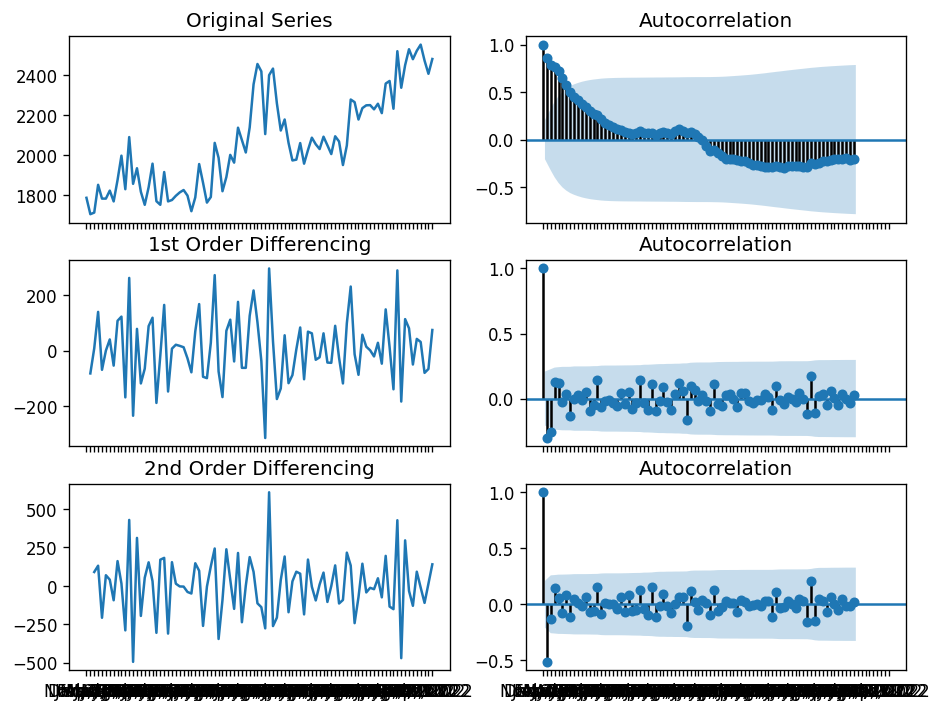

In [ ]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1], lags=80)


# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1], lags=80)

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1], lags=80)

plt.show()

For the above series, the time series reaches stationarity with one orders of differencing. 
So, I am going to fix the order of differencing as 1.

In [ ]:
from pmdarima.arima.utils import ndiffs
df = pd.read_csv(filepath, names=['value'], header=0)
y = df.value

## Adf Test
ndiffs(y, test='adf') 

# KPSS test
ndiffs(y, test='kpss')  

# PP test:
ndiffs(y, test='pp') 

0

find the order of the AR term (p)

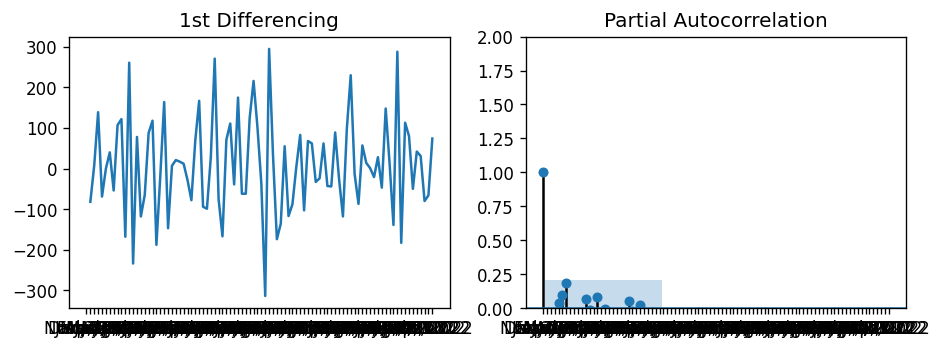

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,2))
plot_pacf(df.value.diff().dropna(), ax=axes[1], lags=30)

plt.show()

You can observe that the PACF lag 1 is quite significant. I am going to fix the p as 1.

find the order of the MA term (q)

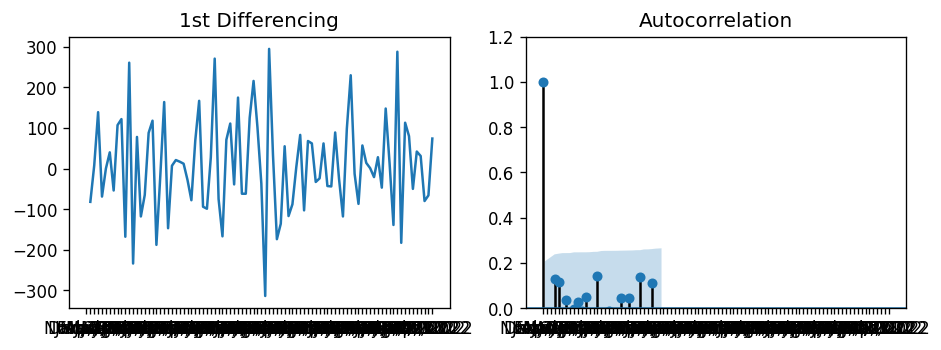

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1], lags=30)

plt.show()

let’s tentatively fix q as 1.

 build the ARIMA Model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA Model
model = ARIMA(df.value, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   89
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -536.184
Method:                       css-mle   S.D. of innovations             99.577
Date:                Thu, 26 May 2022   AIC                           1084.368
Time:                        00:46:37   BIC                           1099.300
Sample:                    12-01-2014   HQIC                          1090.387
                         - 04-01-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.8383      6.703      1.169      0.242      -5.299      20.976
ar.L1.D.value     0.4859      0.249      1.953      0.051      -0.002       0.974
ar.L2.D.value    -0.5456      0.143     

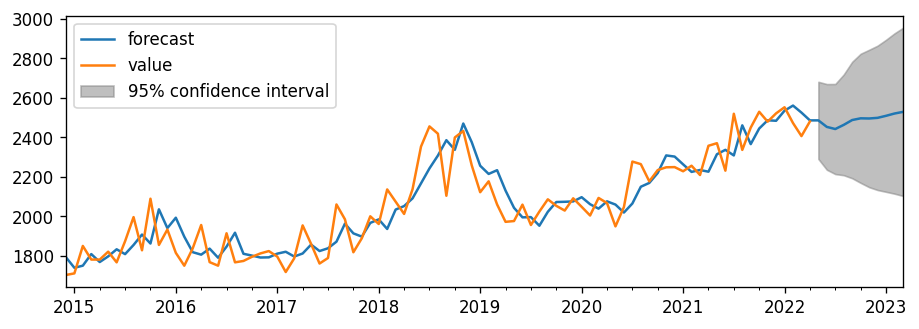

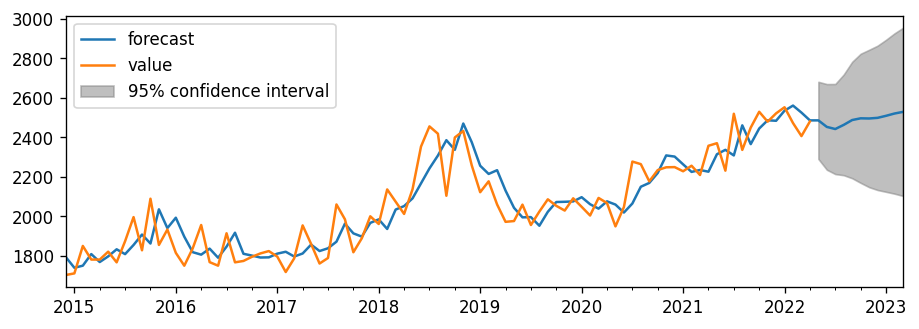

In [ ]:
model_fit.plot_predict(1,100)

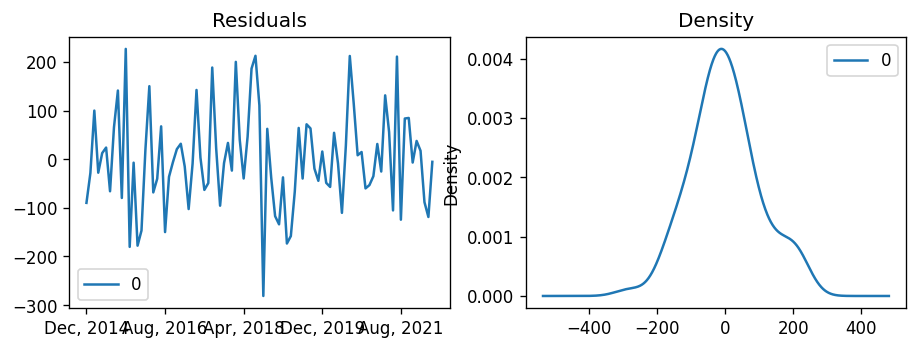

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


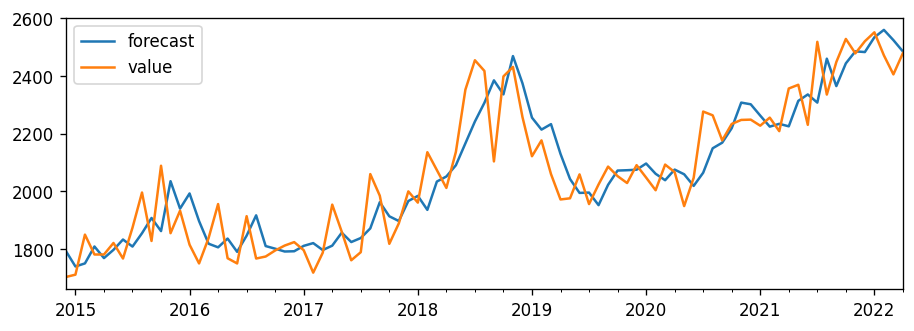

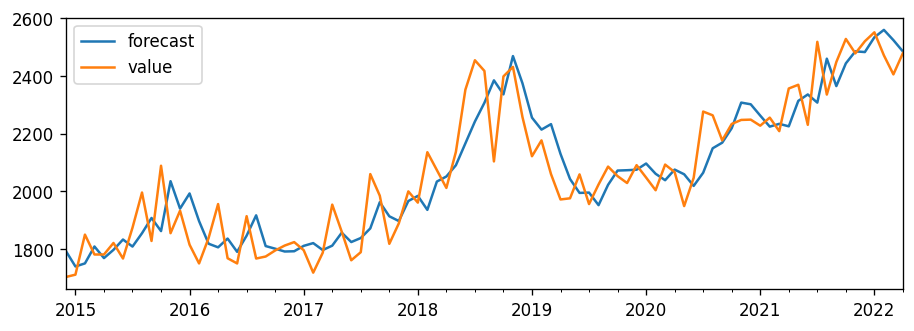

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)

[2264 2177 2234 2248 2249 2228 2256 2209 2357 2370 2231 2519 2336 2449
 2529 2479 2521 2552 2472 2406 2480]


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


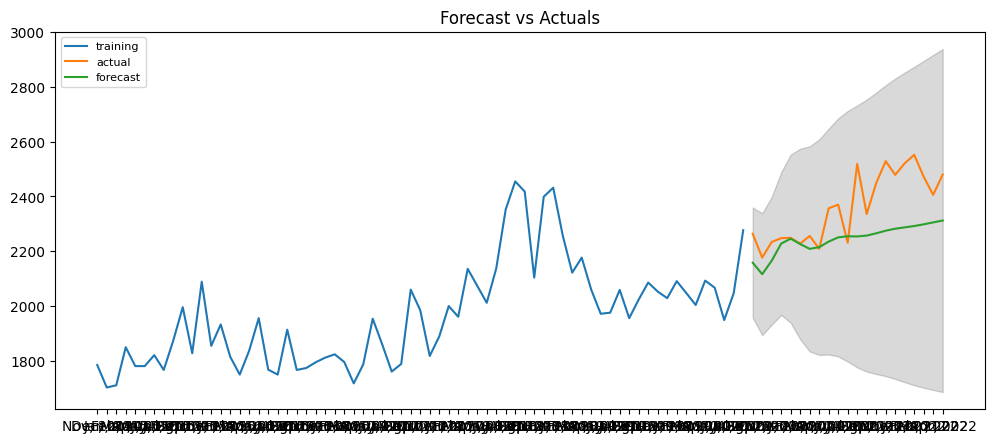

[2158.25500505 2116.41369878 2165.45343701 2228.21178734 2246.01437629
 2226.32518049 2208.82505346 2214.99545554 2235.32272704 2250.8515844
 2254.84909687 2254.16386347 2257.26178969 2265.60783857 2275.13633025
 2282.32355299 2287.28060374 2292.17038844 2298.33925381 2305.38318905
 2312.23970727] [102.76686872 113.5677405  118.99369003 133.01509188 156.60932727
 177.54313665 191.0266778  200.63307223 210.33839697 221.60916784
 233.32845944 243.95269223 253.28068415 262.03087274 270.80324242
 279.63673417 288.2399031  296.42959919 304.27327648 311.93128172
 319.48412161] [[1956.83564355 2359.67436656]
 [1893.8250176  2339.00237996]
 [1932.23009017 2398.67678386]
 [1967.50699785 2488.91657683]
 [1939.0657352  2552.96301737]
 [1878.34702694 2574.30333403]
 [1834.41964489 2583.23046202]
 [1821.76185986 2608.22905123]
 [1823.06704441 2647.57840966]
 [1816.50559679 2685.19757202]
 [1797.53371979 2712.16447394]
 [1776.02537276 2732.30235418]
 [1760.84077078 2753.6828086 ]
 [1752.03676515 277

In [ ]:
#out-of-sample forecasting
#split into train and test sets
from statsmodels.tsa.api import ARIMA
size = len(df.value) - 21
train, test = df.value[0:size], df.value[size:]
print(np.array(test))
# fit an ARIMA model
model2 = ARIMA(train, order=(2,1,2))
model2_fit = model2.fit()
# forecast
fc, se, conf = model2_fit.forecast(steps=21, exog=None, alpha=0.05)
#output: forecast,standard error,confidence interval

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

print(fc, se, conf)

In [ ]:
#predicted value
model_fit.forecast(steps=12, exog=None, alpha=0.05)
#output: forecast, standard error, confidence interval

(array([2485.52775619, 2452.47258331, 2441.69952315, 2462.80644746,
        2487.24750018, 2495.91402491, 2495.09577021, 2498.2755075 ,
        2508.57325187, 2520.14853329, 2528.46081762, 2534.49039582]),
 array([ 99.57720801, 110.58169903, 116.27271727, 129.98724849,
        150.33769157, 166.64129631, 177.32363139, 186.29826312,
        196.21196147, 206.90314028, 216.93182234, 225.82667449]),
 array([[2290.36001482, 2680.69549756],
        [2235.73643586, 2669.20873076],
        [2213.80918492, 2669.58986137],
        [2208.03612196, 2717.57677296],
        [2192.59103919, 2781.90396118],
        [2169.30308581, 2822.52496402],
        [2147.54783908, 2842.64370133],
        [2133.13762141, 2863.41339359],
        [2124.00487406, 2893.14162968],
        [2114.62583005, 2925.67123653],
        [2103.28225873, 2953.6393765 ],
        [2091.87824709, 2977.10254456]]))

##graphs without statsmodel package

In [ ]:
forecast_prices = [2485.52775619, 2452.47258331, 2441.69952315, 2462.80644746,
        2487.24750018, 2495.91402491, 2495.09577021, 2498.2755075 ,
        2508.57325187, 2520.14853329, 2528.46081762, 2534.49039582]
forecast_dates = ['May, 2022', 'Jun, 2022', 'Jul, 2022', 'Aug, 2022', 'Sep, 2022', 'Oct, 2022',
                  'Nov, 2022', 'Dec, 2022', 'Jan, 2023', 'Feb, 2023', 'Mar, 2023', 'Apr, 2023']

In [ ]:
new_df = pd.DataFrame({'value': forecast_prices})
new_df.index = forecast_dates

In [ ]:
result = pd.concat([df, new_df])

In [ ]:
newIndex = []
for i in range(len(result)):
  newIndex.append(i)

result.index = newIndex
result.head

<bound method NDFrame.head of            value
0    1785.000000
1    1703.000000
2    1711.000000
3    1850.000000
4    1781.000000
..           ...
97   2498.275508
98   2508.573252
99   2520.148533
100  2528.460818
101  2534.490396

[102 rows x 1 columns]>

In [ ]:
cv = [[2290.36001482, 2680.69549756],
        [2235.73643586, 2669.20873076],
        [2213.80918492, 2669.58986137],
        [2208.03612196, 2717.57677296],
        [2192.59103919, 2781.90396118],
        [2169.30308581, 2822.52496402],
        [2147.54783908, 2842.64370133],
        [2133.13762141, 2863.41339359],
        [2124.00487406, 2893.14162968],
        [2114.62583005, 2925.67123653],
        [2103.28225873, 2953.6393765 ],
        [2091.87824709, 2977.10254456]]

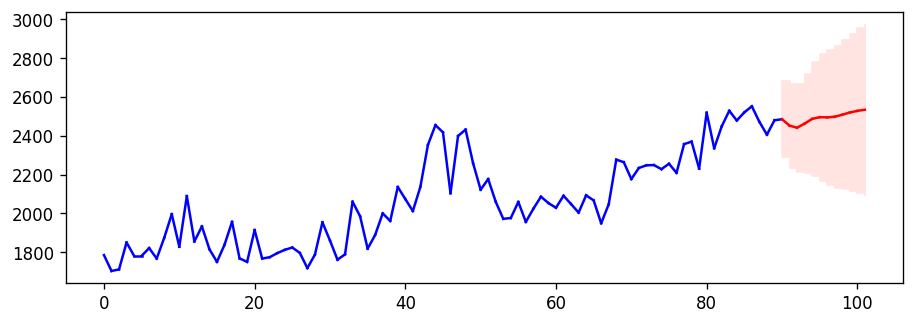

In [ ]:
cvIndex = 0
for i in range(0, len(result), 1):
  if i < len(df):
    plt.plot(result.index[i:i+2], result.value[i:i+2], '-k', color='blue')
  else:
    plt.plot(result.index[i:i+2], result.value[i:i+2], '-k', color='red')
    plt.fill_between(result.index[i:i+2], cv[cvIndex][0], cv[cvIndex][1], color='mistyrose', facecolor=(1,0,0,.4), edgecolor=(0,0,0,.5))
    cvIndex+=1